In [ ]:
!pip install -r requirements.txt

In [2]:
# NLP related
import nltk
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import transformers
from transformers import BertForSequenceClassification
from transformers import BertTokenizer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import torch
from torch.utils.data import DataLoader, Dataset

# Others
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from IPython.display import clear_output

# Работа с данными

### Загрузка данных

In [3]:
train = pd.read_csv('dataset/train.tsv', sep='\t')
test = pd.read_csv('dataset/test.tsv', sep='\t')

In [4]:
train.head(3)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1


### EDA

Предобработка текстовых данных сильно влияет на качество итогового решения.

Преобразования, которые могут улучшить качество: 

1) Привести слова к нижнему регистру

2) Удалить знаки препинания и числа

3) Токенизировать текст

4) Лемматизация (приведение слова к нормальной форме)

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

morph = MorphAnalyzer()

In [6]:
def preprocess(text):
    # 1, 2, 3
    tokens = list(filter(str.isalpha, word_tokenize(text.lower(), language='russian')))
    # 4
    tokens = [parsed[0].normal_form for parsed in map(morph.parse, tokens)]
    return tokens

In [7]:
# Проверка предобработки
preprocess('Москвичу Владимиру пришёл счёт за воду.')

['москвич', 'владимир', 'прийти', 'счёт', 'за', 'вода']

In [8]:
train['data'] = train.apply(lambda row: preprocess(row.title), axis=1)

### Разбиение данных

Для локального тестирования разобьем обучающую выборку на обучающую и валидационную

In [9]:
train, val = train_test_split(train, test_size=0.1, random_state=42)

# План работы

Рассмотрим несколько методов обработки текстовых данных=.

1) Сначала получим tf-idf векторы текстов и обучим на них "обычный" классфикатор. Таким образом, мы получим представление о задаче и своего рода "бейзлайн" для более сложных архитектур.

2) Затем, воспользуемся сложной моделью. А именно, попробуем дообучить предобученный BERT с головой-классификатором на наших текстах.

# Часть 1: Классификация на tf-idf векторах

Для `TfidfVectorizer` нужно сначала склеить токены в предложения:

In [10]:
train_text = train.data.apply(' '.join)
val_text = val.data.apply(' '.join)

Получим tf-idf векторы наших текстов:

In [11]:
tf_idf = TfidfVectorizer(lowercase=False).fit(train_text)

Подготовим данные для обучения:

In [12]:
X_train = tf_idf.transform(train_text)
X_val = tf_idf.transform(val_text)
y_train = train.is_fake
y_val = val.is_fake

### Логистическая регрессия

Сразу подберем коэффициент регуляризации с помощью валидации по отложенной выборке.

In [13]:
best_C = 0.
best_f1 = 0.

C_range = np.logspace(3, 5, num=10)

for C in tqdm(C_range, desc='Validating', ncols=80):
    model = LogisticRegression(C=C)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        model.fit(X_train, y_train)
    pred = model.predict(X_val)
    f1 = f1_score(y_val, pred)
    if f1 > best_f1:
        best_C = C
        best_f1 = f1

Validating: 100%|███████████████████████████████| 10/10 [00:02<00:00,  4.40it/s]


In [14]:
best_C

2782.559402207126

In [15]:
f1_logreg = best_f1
print('Значения F1 метрики\n')
print(f'Логистическая регрессия: {f1_logreg}')

Значения F1 метрики

Логистическая регрессия: 0.8407224958949097


### SVM

Как и в случае с логистической регрессией, будем подбирать коэффициент регуляризации. Также, попробуем разные виды SVM, чтобы найти лучший: линейный и ядровой (ядра также попробуем разные)

In [16]:
best_C = 0.
best_kernel = ''
best_f1 = 0.

C_range = np.logspace(0, 2, num=10)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for C in tqdm(C_range, desc='Validating', ncols=80):
    for kernel in kernels:
        model = SVC(C=C, kernel=kernel)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            model.fit(X_train, y_train)
        pred = model.predict(X_val)
        f1 = f1_score(y_val, pred)
        if f1 > best_f1:
            best_C = C
            best_f1 = f1
            best_kernel = kernel

Validating: 100%|███████████████████████████████| 10/10 [02:09<00:00, 12.92s/it]


In [17]:
best_C, best_kernel

(1.0, 'rbf')

In [18]:
f1_svm = best_f1
print('Значения F1 метрики\n')
print(f'Логистическая регрессия: {f1_logreg}')
print(f'SVM + RBF ядро: {f1_svm}')

Значения F1 метрики

Логистическая регрессия: 0.8407224958949097
SVM + RBF ядро: 0.858569051580699


### Итоги части 1

Лучшее качество на tf-idf векторах получилось достичь с помощью ядрового SVM с RBF ядром.

Опираясь на полученные значения метрик, при работе с BERT-ом будем ориентироваться на `F1 > 0.86`.

# Часть 2: BERT

### Подготовка

Зафиксируем `seed` для воспроизводимости результатов.

In [20]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_random_seed(101)

Определим функцию для отрисовки графиков в процессе обучения.

In [21]:
def plot_scores(train_losses, eval_losses, train_metrics, eval_metrics):
    clear_output()
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
    # Losses
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(eval_losses) + 1), eval_losses, label='eval')
    axs[0].set_ylabel('Ошибка')
    axs[0].set_xlabel('Эпоха')
    axs[0].set_title('Ошибка во время обучения')
    axs[0].legend()
    # Metrics
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(eval_metrics) + 1), eval_metrics, label='eval')
    axs[1].set_ylabel('F1')
    axs[1].set_xlabel('Эпоха')
    axs[1].set_title('Значение F1 во время обучения')
    axs[1].legend()

    axs[0].grid()
    axs[1].grid()
    plt.show()

Создадим датасеты из наших данных и положим их в DataLoader.

In [22]:
class NewsDataset(Dataset):
    def __init__(self, data, target=None):
        self.X = data
        if target is None:
            self.y = None
        else:
            self.y = torch.tensor(target, dtype=torch.long)
        self.len = len(self.X)

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

In [23]:
BATCH_SIZE = 8

train_dataset = NewsDataset(train.title.values.tolist(), target=y_train.values)
eval_dataset = NewsDataset(val.title.values.tolist(), target=y_val.values)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Модель и прочие радости

На сайте `huggingface` есть великое множество моделей, предобученных на самые разные задачи. В том числе, на задачи, связанные с русским языком.

---

Были рассмотрены следующие предобученные модели.

- `sberbank-ai/ruBert-base`: русский BERT-base

best eval F1 = 0.9505

- `DeepPavlov/rubert-base-cased`: отличается от предыдущей модели задачей предобучения

best eval F1 = 0.9372

- `blinoff/roberta-base-russian-v0`: русская RoBERTa-base

best eval F1 = 0.8799

- `SkolkovoInstitute/rubert-base-corruption-detector`: модель, обученная отличать написанный человеком текст от намеренно испорченного текста

best eval F1 = 0.9264

---

Среди рассмотренных моделей `sberbank-ai/ruBert-base` показала наилучшее качество на отложенной выборке. Ниже приведен код ее дообучения.

In [ ]:
# Определяем девайс
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

# Загружаем предобученную модель
model = BertForSequenceClassification.from_pretrained('sberbank-ai/ruBert-base', num_labels=2)
model = model.to(device)
# Загружаем токенайзер для этой модели
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base', do_lower_case=False)

# Оптимизатор
optimizer = transformers.AdamW(model.parameters(), lr=1e-5)

Трансформеры принимают на вход последовательность токенов фиксированной длины. Для этого мы будем добавлять нулевой паддинг к слишком кортким предложениям, и обрезать слишком длинные - все это контролируется в токенайзере.

Нам остается лишь зафиксировать необходимую длину.

In [25]:
MAX_LEN = 512

Последний штрих, избавимся от предупреждений, которые будут сыпаться от токенайзера во время обучения.

In [26]:
transformers.utils.logging.set_verbosity_error()

### Обучение

Дообучать BERT рекомендуется с использованием расписания `lr` с `warmup` и небольшим пороговым значением `lr`. 

Мы уже взяли `lr=1e-5`, в расписании для `warmup`-а возьмем 0.06 шагов от общего числа.

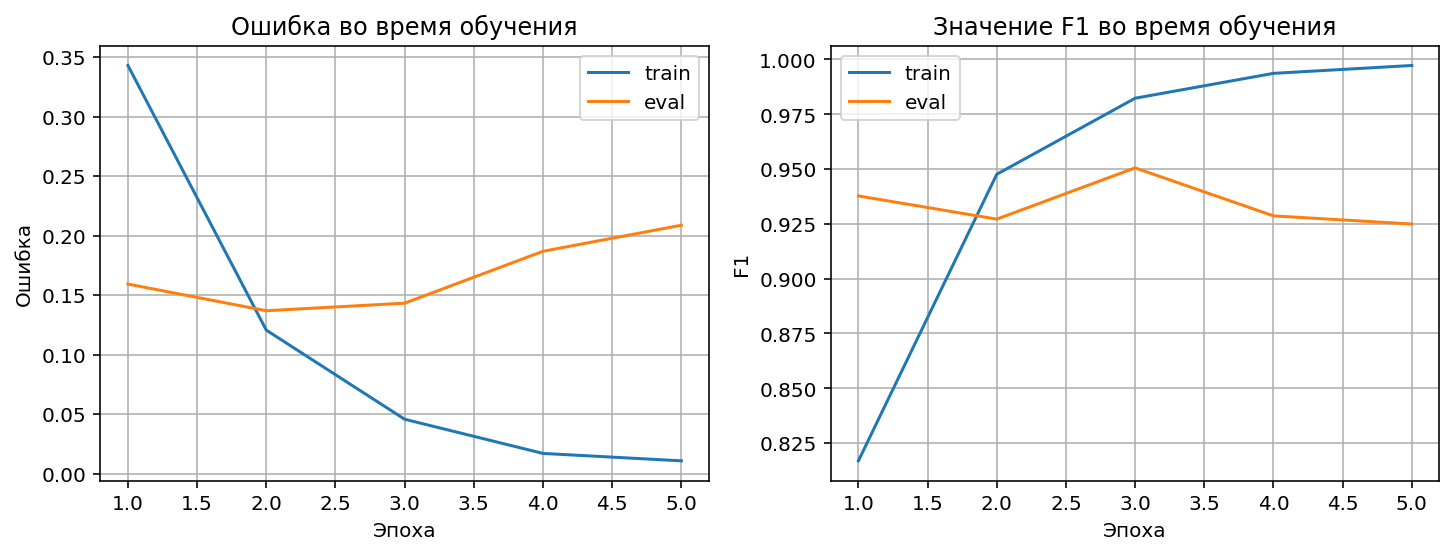

Best eval F1: 0.9505, on epoch: 3


In [27]:
NUM_EPOCHS = 5

# Расписание lr
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * num_training_steps,
    num_training_steps=num_training_steps
)

# Хранилище важной информации о ходе обучения
train_losses, train_metrics = [], []
eval_losses, eval_metrics = [], []
best_eval_f1 = 0.
best_eval_epoch = 0

for n in range(NUM_EPOCHS):
    '''
    TRAINING
    '''
    model.train()
    train_loss = 0.
    train_f1 = 0.
    for titles, targets in tqdm(train_dataloader, desc=f'Training {n + 1}/{NUM_EPOCHS}', ncols=80):
        tokenized_batch = tokenizer(
            list(titles),
            padding='max_length', 
            max_length=MAX_LEN, 
            truncation=True,
            return_tensors='pt')
        tokenized_batch = tokenized_batch.to(device)
        targets = targets.to(device)
        outputs = model(**tokenized_batch, labels=targets)
        preds = outputs.logits
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item() * len(titles)
        true_labels = targets.cpu().detach().numpy()
        pred_labels = np.argmax(preds.cpu().detach().numpy(), axis=1)
        train_f1 += f1_score(true_labels, pred_labels, zero_division=1) * len(titles)

    train_losses += [train_loss / len(train_dataset)]
    train_metrics += [train_f1 / len(train_dataset)]

    '''
    VALIDATING
    '''
    model.eval()
    eval_loss = 0.
    eval_f1 = 0.
    for titles, targets in tqdm(eval_dataloader, desc=f'Evaluating {n + 1}/{NUM_EPOCHS}', ncols=80):
        tokenized_batch = tokenizer(
            list(titles),
            padding='max_length', 
            max_length=MAX_LEN, 
            truncation=True,
            return_tensors='pt')
        tokenized_batch = tokenized_batch.to(device)
        targets = targets.to(device)        
        with torch.no_grad():
            outputs = model(**tokenized_batch, labels=targets)
            preds = outputs.logits
            loss = outputs.loss
        
        eval_loss += loss.item() * len(titles)
        true_labels = targets.cpu().detach().numpy()
        pred_labels = np.argmax(preds.cpu().detach().numpy(), axis=1)
        eval_f1 += f1_score(true_labels, pred_labels, zero_division=1) * len(titles)  
    
    eval_losses += [eval_loss / len(eval_dataset)]
    eval_metrics += [eval_f1 / len(eval_dataset)]

    # Обновим лучшее значение метрики
    if best_eval_f1 < eval_metrics[-1]:
        best_eval_f1 = eval_metrics[-1]
        best_eval_epoch = n
        # Сохраняем модель
        network_state = dict(
            [(k, v.cpu()) for k, v in model.state_dict().items()]
        )
        state_path = './checkpoint_best.pt'
        torch.save(network_state, state_path)

    # Графики ошибки и значений метрики во время обучения
    plot_scores(train_losses, eval_losses, train_metrics, eval_metrics)
    
    # Напомним себе, каким было лучшее значение метрики на отложенной выборке
    print(f'Best eval F1: {best_eval_f1:.4f}, on epoch: {best_eval_epoch + 1}')

### Формируем предсказания

Загрузим лучшую по значению метрики на отложенной выборке модель.

In [28]:
model.load_state_dict(torch.load('./checkpoint_best.pt'))

<All keys matched successfully>

Подготовим тестовые данные для того, чтобы подать их в модель.

In [29]:
test_dataset = NewsDataset(test.title.values.tolist())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Получим вектор предсказаний модели для тестовой выборки.

In [30]:
model.eval()
labels = np.array([])
for titles in tqdm(test_dataloader, desc=f'Processing test', ncols=80):
    tokenized_batch = tokenizer(
        titles,
        padding='max_length', 
        max_length=MAX_LEN, 
        truncation=True,
        return_tensors='pt')
    tokenized_batch = tokenized_batch.to(device)

    with torch.no_grad():
        preds = model(**tokenized_batch).logits

    labels = np.concatenate(
        (
            labels,
            np.argmax(preds.cpu().detach().numpy(), axis=1)
        )
    )

Processing test: 100%|████████████████████████| 125/125 [00:35<00:00,  3.52it/s]


Осталось сохранить эти предсказания в тестовый DataFrame и сохранить все в файл `predictions.tsv`.

In [31]:
test['is_fake'] = labels

In [32]:
test.to_csv('./predictions.tsv', sep='\t', index=False)